In [4]:
import os, sys
import importlib
import torch

import numpy as np

import matplotlib.pyplot as plt

from utils import load_torch, load

In [5]:
importlib.reload(load_torch)

data_folder = "quickdraw/train_simplified/"
access_file_generator = map(lambda x : data_folder + x + '.csv', load.classes)
trainGenerator = load_torch.ImageLoader(load.classes, data_folder)

In [6]:
gen = trainGenerator.__iter__()

X.shape: torch.Size([16, 1, 32, 32])
y.shape: torch.Size([16])


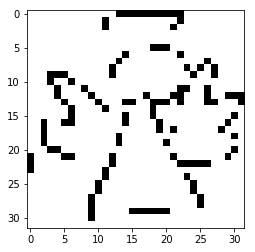

In [11]:
%matplotlib inline
X, y = next(gen)
print('X.shape:', X.shape)
print('y.shape:', y.shape)

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as ag
import torch.optim as optim


class VanillaDoodle(nn.Module):
    # Here we define our network structure
    def __init__(self, cdim=8):
        super(VanillaDoodle, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3).double() 
        self.conv2 = nn.Conv2d(6,16, 3).double()
        self.conv3 = nn.Conv2d(16,32,3).double()
        self.conv4 = nn.Conv2d(32,64,3).double()
        self.fc1   = nn.Linear(128,120).double()
        self.fc2   = nn.Linear(120, 84).double() 
        self.fc3   = nn.Linear(84,cdim).double()
        
        self.maxunpool1=nn.MaxUnpool2d(2, stride=2)
        self.maxunpool2=nn.MaxUnpool2d(2, stride=2)
        self.maxunpool3=nn.MaxUnpool2d(2, stride=2)
        self.deconv1 = nn.ConvTranspose2d(6, 1, 3).double()
        self.deconv2 = nn.ConvTranspose2d(16, 6, 3).double()
        self.deconv3 = nn.ConvTranspose2d(32, 16, 3).double()
        
    # Here we define one forward pass through the network
    def forward(self, x):
        x, indices1 = F.max_pool2d(F.relu(self.conv1(x)), (2, 2), return_indices = True)
        y_unpool1=self.deconv1(F.relu(self.maxunpool1(x,indices1)))
        #plt.imshow(y_unpool1[0,...])
        
        array= y_unpool1.detach().numpy()
        array_img = array[127,0,:,:]
        print(array_img.shape)
        plt.title("Layer1")
        plt.imshow(array_img)
        plt.show()
        #print(array_img.shape)
        output_size = self.conv2(x).size()
        x, indices2 = F.max_pool2d(F.relu(self.conv2(x)), (2, 2), return_indices = True)
        y_unpool2=self.deconv2(F.relu(self.maxunpool2(x,indices2, output_size)))
        array= y_unpool2.detach().numpy()
        array_img = array[127,0,:,:]
        plt.title("Layer2")
        plt.imshow(array_img)
        plt.show()
        
        x, indices3 = F.max_pool2d(F.relu(self.conv3(x)), (2, 2),return_indices = True)
        y_unpool3=self.deconv3(F.relu(self.maxunpool3(x,indices3)))
        x = x.view(-1, int(self.num_flat_features(x)))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
    # Determine the number of features in a batch of tensors
    def num_flat_features(self, x): 
        size = x.size()
        return np.prod(size[1:])
    

In [24]:
B     = 128              # Minibatch size
T     = 1               # Number of epochs
gamma = .001             # learning rate
rho   = .9               # momentum

classes = load.classes
    
net = VanillaDoodle(cdim=len(classes))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    net.parameters(),
    lr=gamma,
    momentum=rho
)

(32, 32)


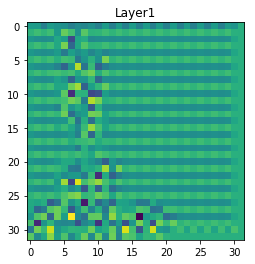

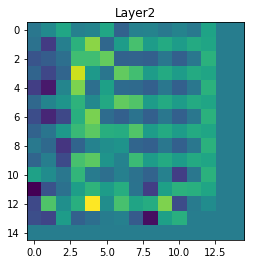

(32, 32)


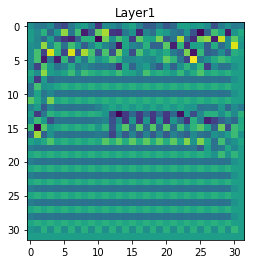

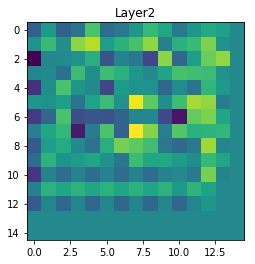

(32, 32)


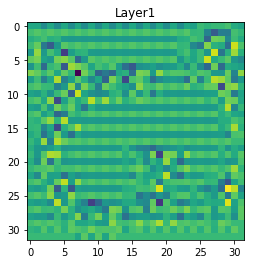

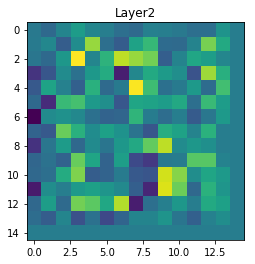

(32, 32)


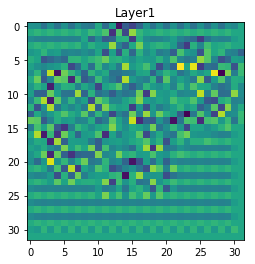

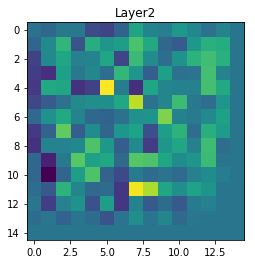

(32, 32)


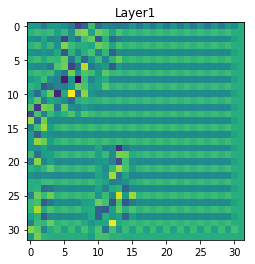

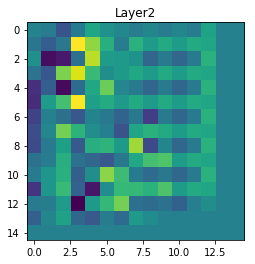

(32, 32)


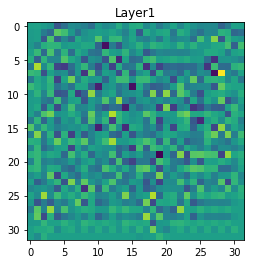

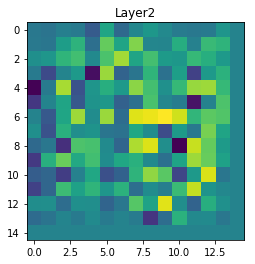

(32, 32)


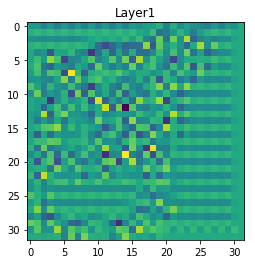

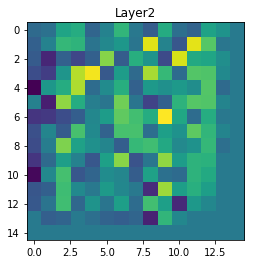

(32, 32)


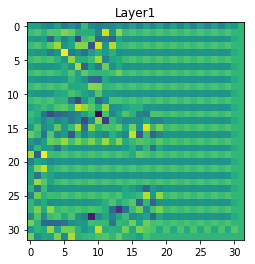

KeyboardInterrupt: 

In [25]:
device = torch.device('cuda:0')
#if torch.cuda.is_available():
   #net = net.cuda()

accList, lossList = list(), list()
accuracy = [0]
loss_stored = []
for epoch in range(T):            
    gen = load_torch.ImageLoader(classes=load.classes,root_location=data_folder,read_size=32,batch_size=128)
    for i, (images, labels) in enumerate(gen):
        images = images
        labels = labels
        
        
        # Forward pass
        outputs = net(images)
        
        loss = criterion(outputs.cpu(), labels)
        acc = 100 * np.mean(labels.data.numpy() == outputs.cpu().data.numpy ().T.argmax(axis =0))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        del images
        del labels
        del outputs

        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}], Loss: {:.4f}, Accuracy:{:.4f}' .format(epoch+1, T, i+1, loss.item(),acc))
            #model.save_state_dict('mytraining.pt')
        if (i+1)%100==0:
            loss_stored.append(loss.item())
            accuracy.append((0.1*acc) + (0.9*accuracy[-1]))
    